In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import glob
import dateutil
import datetime

from pycountry import countries

from data_loading import TwitterDataLoader, WhoDataLoader

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

In [2]:
twitter_data = TwitterDataLoader('./data/twitter/')
who_data = WhoDataLoader('./data/who/')

In [3]:
sample_twitter_data = who_data.get_data('IT', 'death')
sample_twitter_data

2020-01-22      NaN
2020-01-23      0.0
2020-01-24      0.0
2020-01-25      0.0
2020-01-26      0.0
              ...  
2020-04-26    260.0
2020-04-27    333.0
2020-04-28    382.0
2020-04-29    323.0
2020-04-30    285.0
Length: 100, dtype: float64

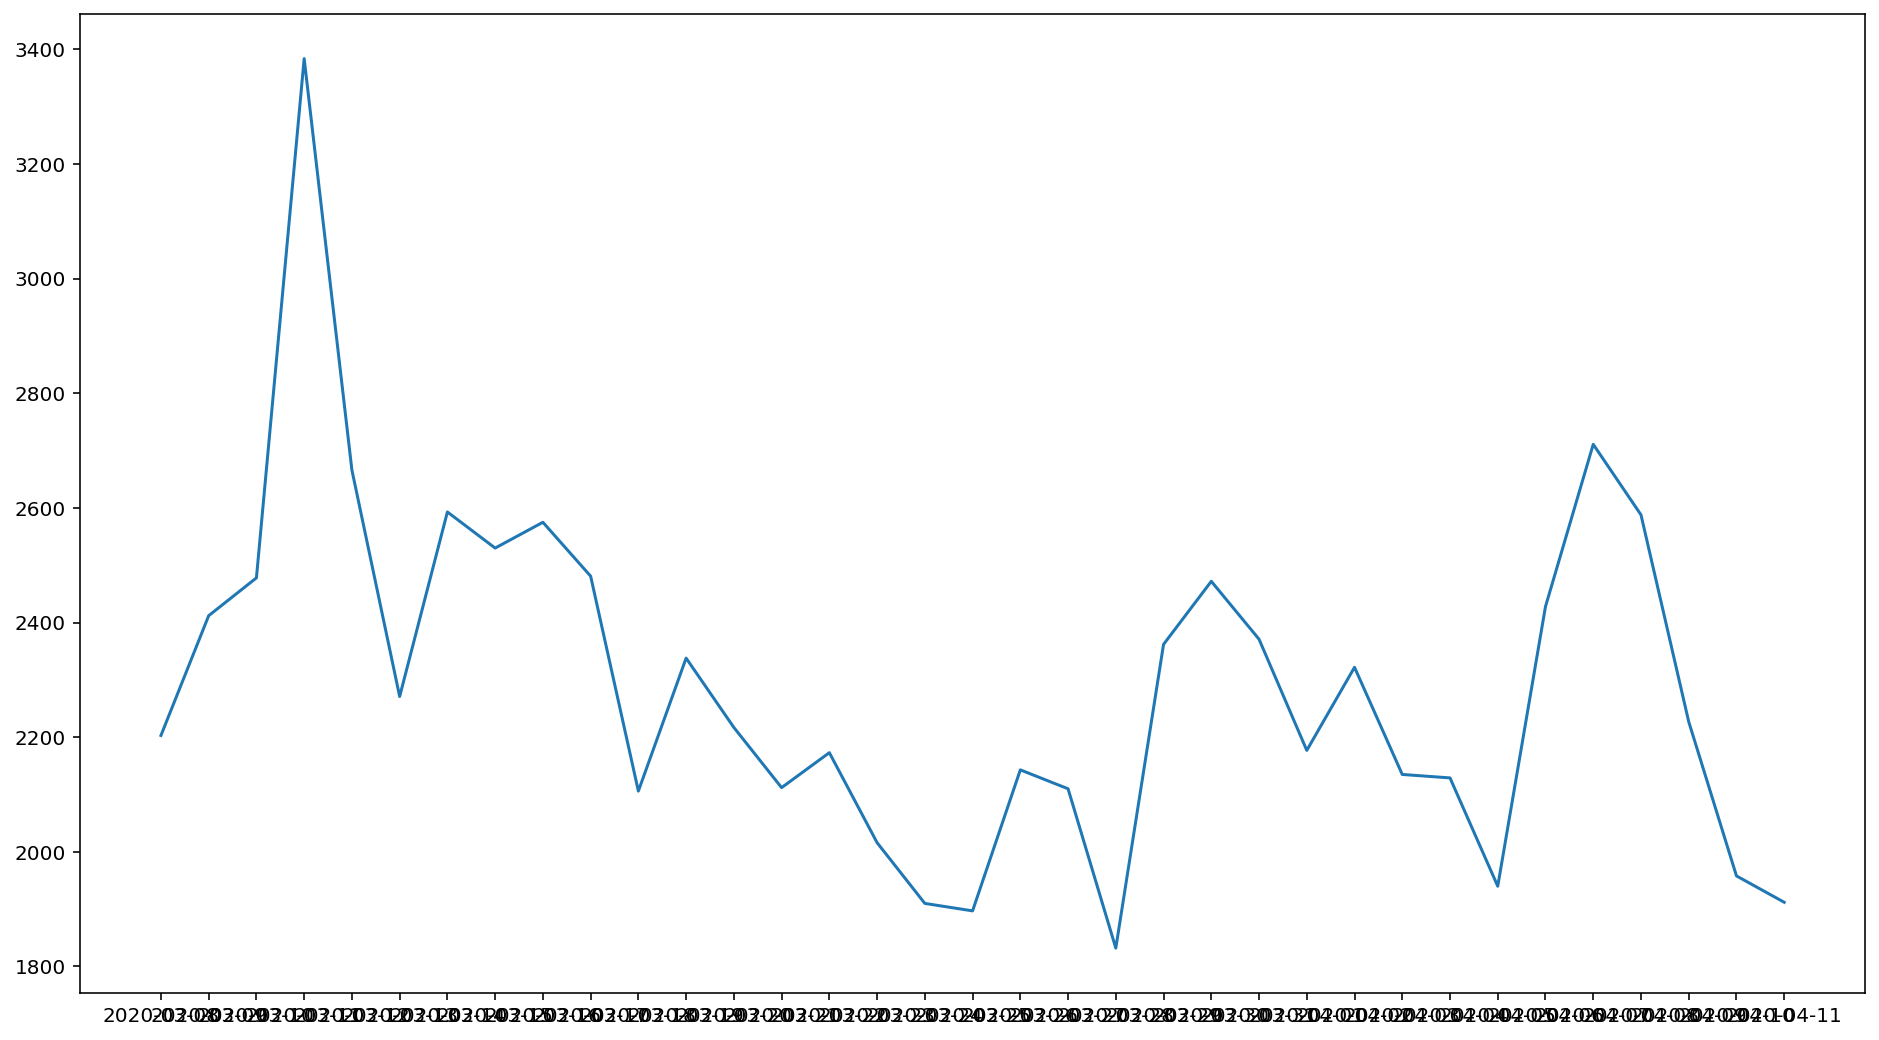

In [4]:
valid_dates_range = ('8 mar 2020', '11 apr 2020')

sample_data = twitter_data.get_data('PL', valid_dates_range)
plt.plot(sample_data)

In [5]:
sample_data.values

array([2203, 2412, 2478, 3384, 2666, 2271, 2593, 2530, 2575, 2481, 2106,
       2338, 2217, 2112, 2173, 2016, 1910, 1897, 2143, 2110, 1832, 2362,
       2472, 2371, 2177, 2322, 2135, 2129, 1940, 2428, 2711, 2588, 2227,
       1958, 1912])

In [6]:
def decompose(pd_series, mean_window_size):
    if mean_window_size % 2 == 0:
        raise Exception('mean window must have odd length')
    
    data = pd_series.values
    index = pd_series.index.values
    
    margin = mean_window_size // 2
    data_cut = data[margin:-margin]
    index_cut = index[margin:-margin]
    
    kernel = np.ones(mean_window_size) / mean_window_size
    trend = np.convolve(data, kernel, mode='valid')
    residuals = data_cut - trend
    
    trend_series = pd.Series(trend, index_cut)
    residuals_series = pd.Series(residuals, index_cut)
    
    return {
        'trend': trend_series,
        'residuals': residuals_series
    }

In [7]:
decomposed_data = decompose(sample_data, mean_window_size=5)

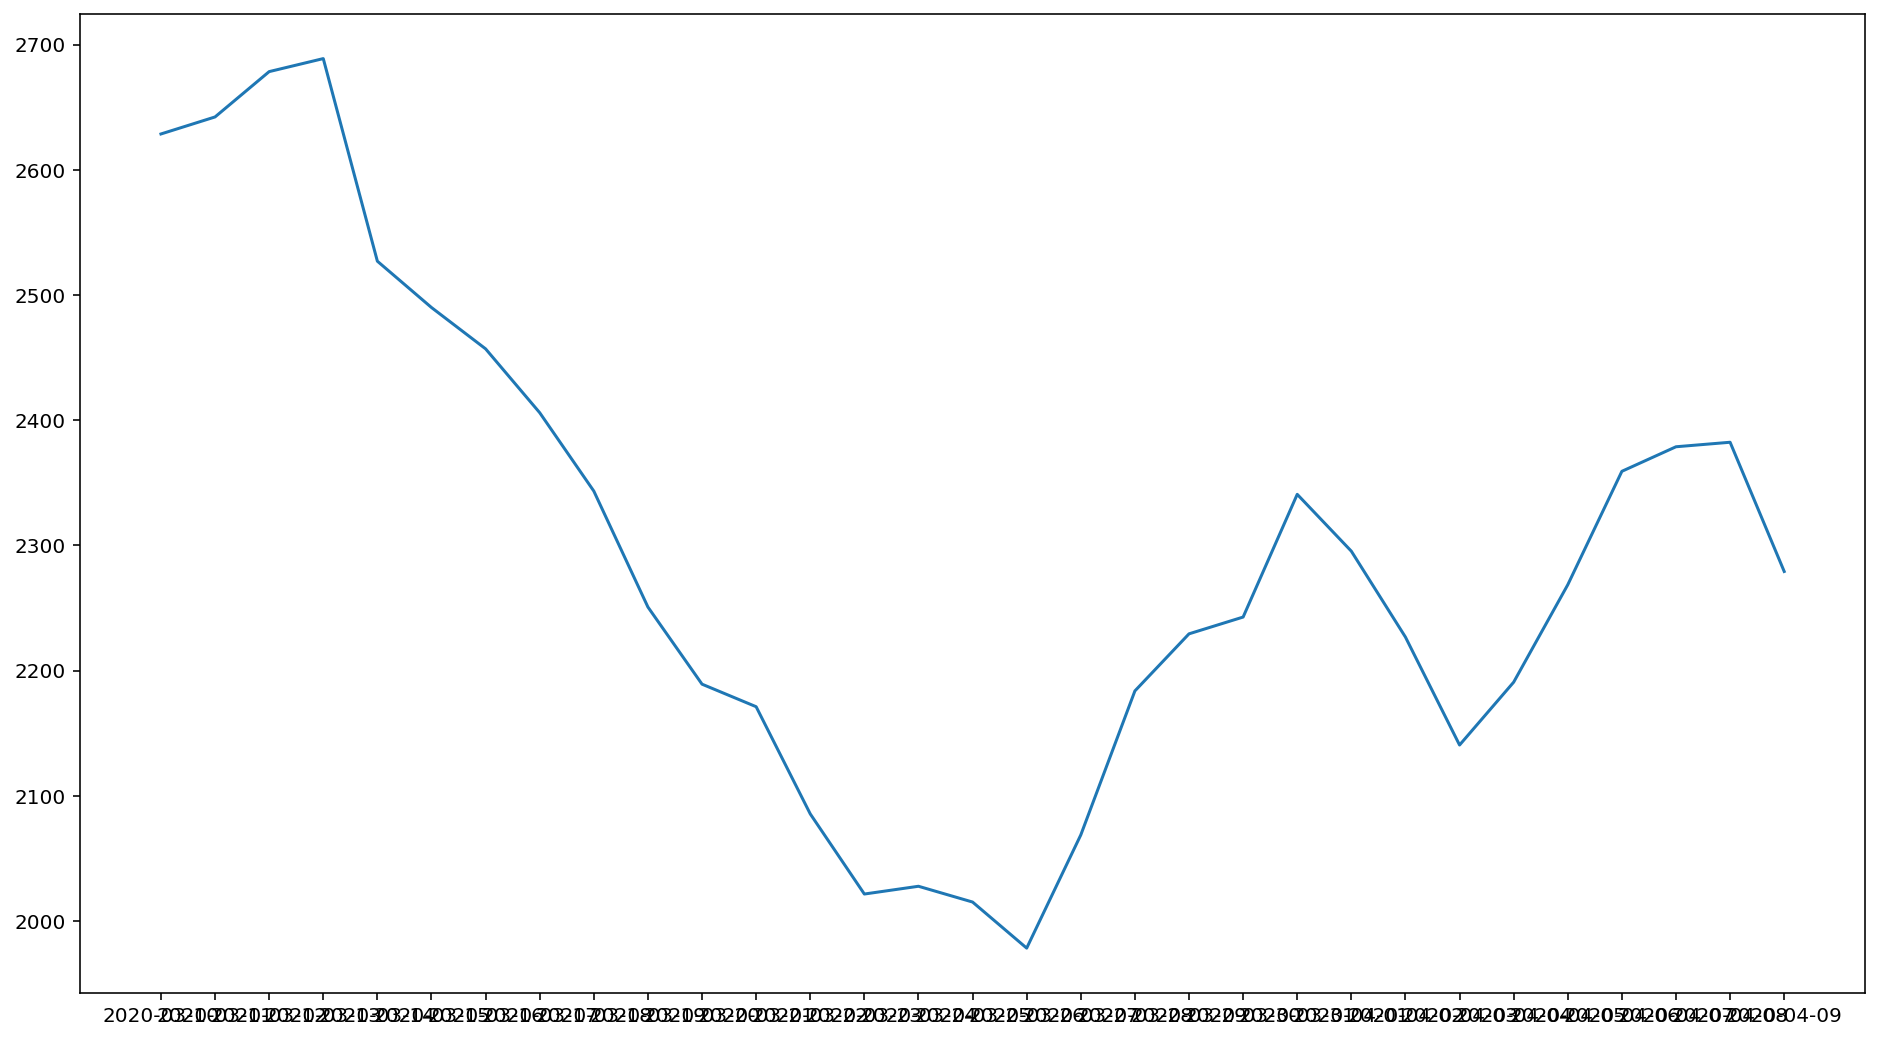

In [8]:
plt.plot(decomposed_data['trend'])

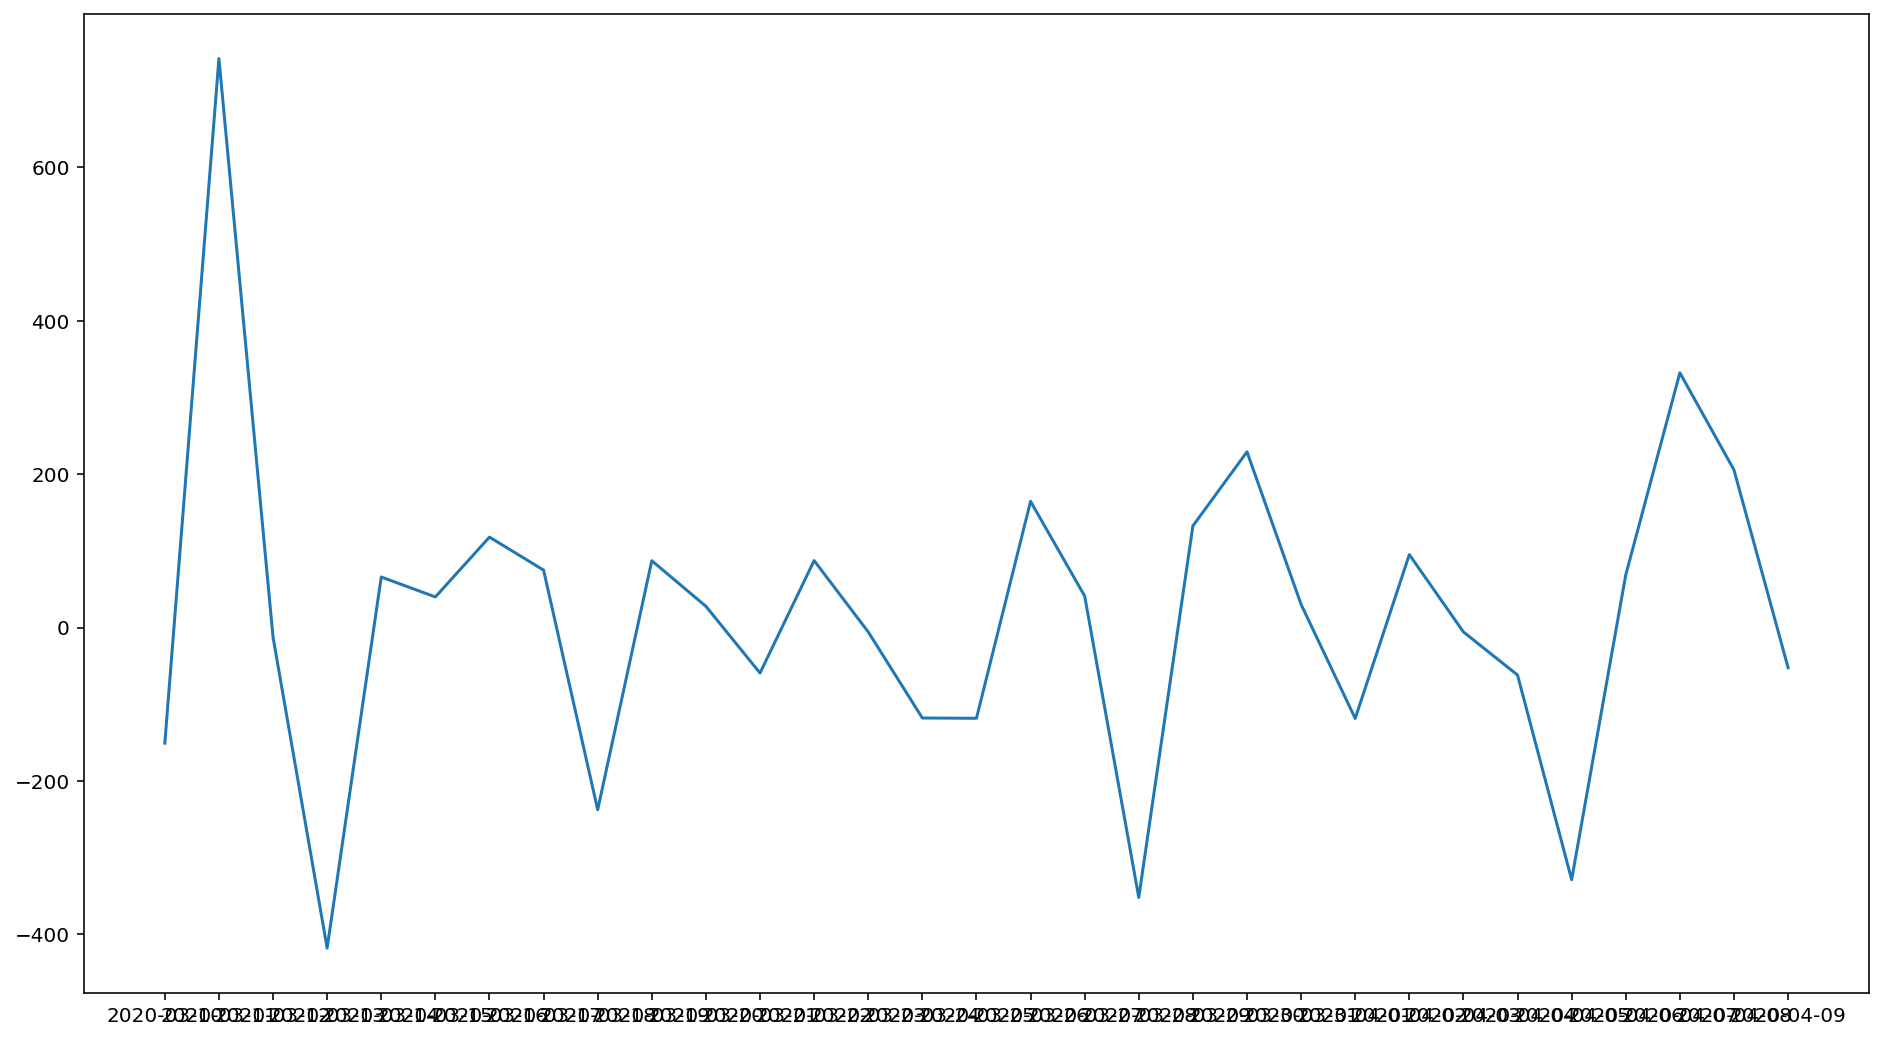

In [9]:
plt.plot(decomposed_data['residuals'])

## summarize correlations

In [71]:
%%time

# valid_dates_range = ('8 mar 2020', '11 apr 2020')

alpha_codes = [c.alpha_2 for c in countries]
who_source = 'confirmed'
window_size = 7

results = {}

for code in alpha_codes:
    
    try:
        twitter = twitter_data.get_data(code, valid_dates_range)
        who = who_data.get_data(code, who_source, valid_dates_range)
        
        twitter_dec = decompose(twitter, window_size)
        who_dec = decompose(who, window_size)

        trend_c = twitter_dec['trend'].corr(who_dec['trend'])
        res_c = twitter_dec['residuals'].corr(who_dec['residuals'])

        if np.isnan(trend_c) or np.isnan(res_c):
            print(code)
            continue
            
        results[code] = (trend_c, res_c)
    except KeyError:
        pass

KM
GW
TJ
CPU times: user 911 ms, sys: 20.4 ms, total: 931 ms
Wall time: 899 ms


In [72]:
sorted_by_trend = sorted([(k, v[1]) for k, v in results.items()], key=lambda x: x[1])

In [73]:
sorted_by_trend

[('DM', -0.6657091596654492),
 ('EH', -0.5293991453815725),
 ('MU', -0.45214381762715705),
 ('NL', -0.4066172783624113),
 ('HU', -0.4057798202192871),
 ('VC', -0.353488817232633),
 ('MD', -0.3389534663453447),
 ('HR', -0.3157194572355999),
 ('DO', -0.2614505791376899),
 ('TL', -0.25466639382291395),
 ('BG', -0.2447831670978432),
 ('CA', -0.2409994197162936),
 ('ZW', -0.23804524198073332),
 ('EG', -0.23800755882071092),
 ('DJ', -0.21814670728144175),
 ('BF', -0.21136246049558752),
 ('MR', -0.20711695305451497),
 ('SZ', -0.20618585251565932),
 ('IE', -0.19849211605110031),
 ('ST', -0.19442590748632846),
 ('NZ', -0.18204190006872598),
 ('SI', -0.17287248673626143),
 ('KN', -0.17266112583311483),
 ('PK', -0.16130309959524722),
 ('SC', -0.14709422390736504),
 ('BE', -0.1422596881758374),
 ('BJ', -0.1416688108531654),
 ('SL', -0.14113887499038522),
 ('NG', -0.13873863523086324),
 ('DZ', -0.13248603064270695),
 ('AD', -0.13033731099680504),
 ('LT', -0.12353521929815636),
 ('LR', -0.1149130683

Text(0.5, 1.0, 'twitter activity')

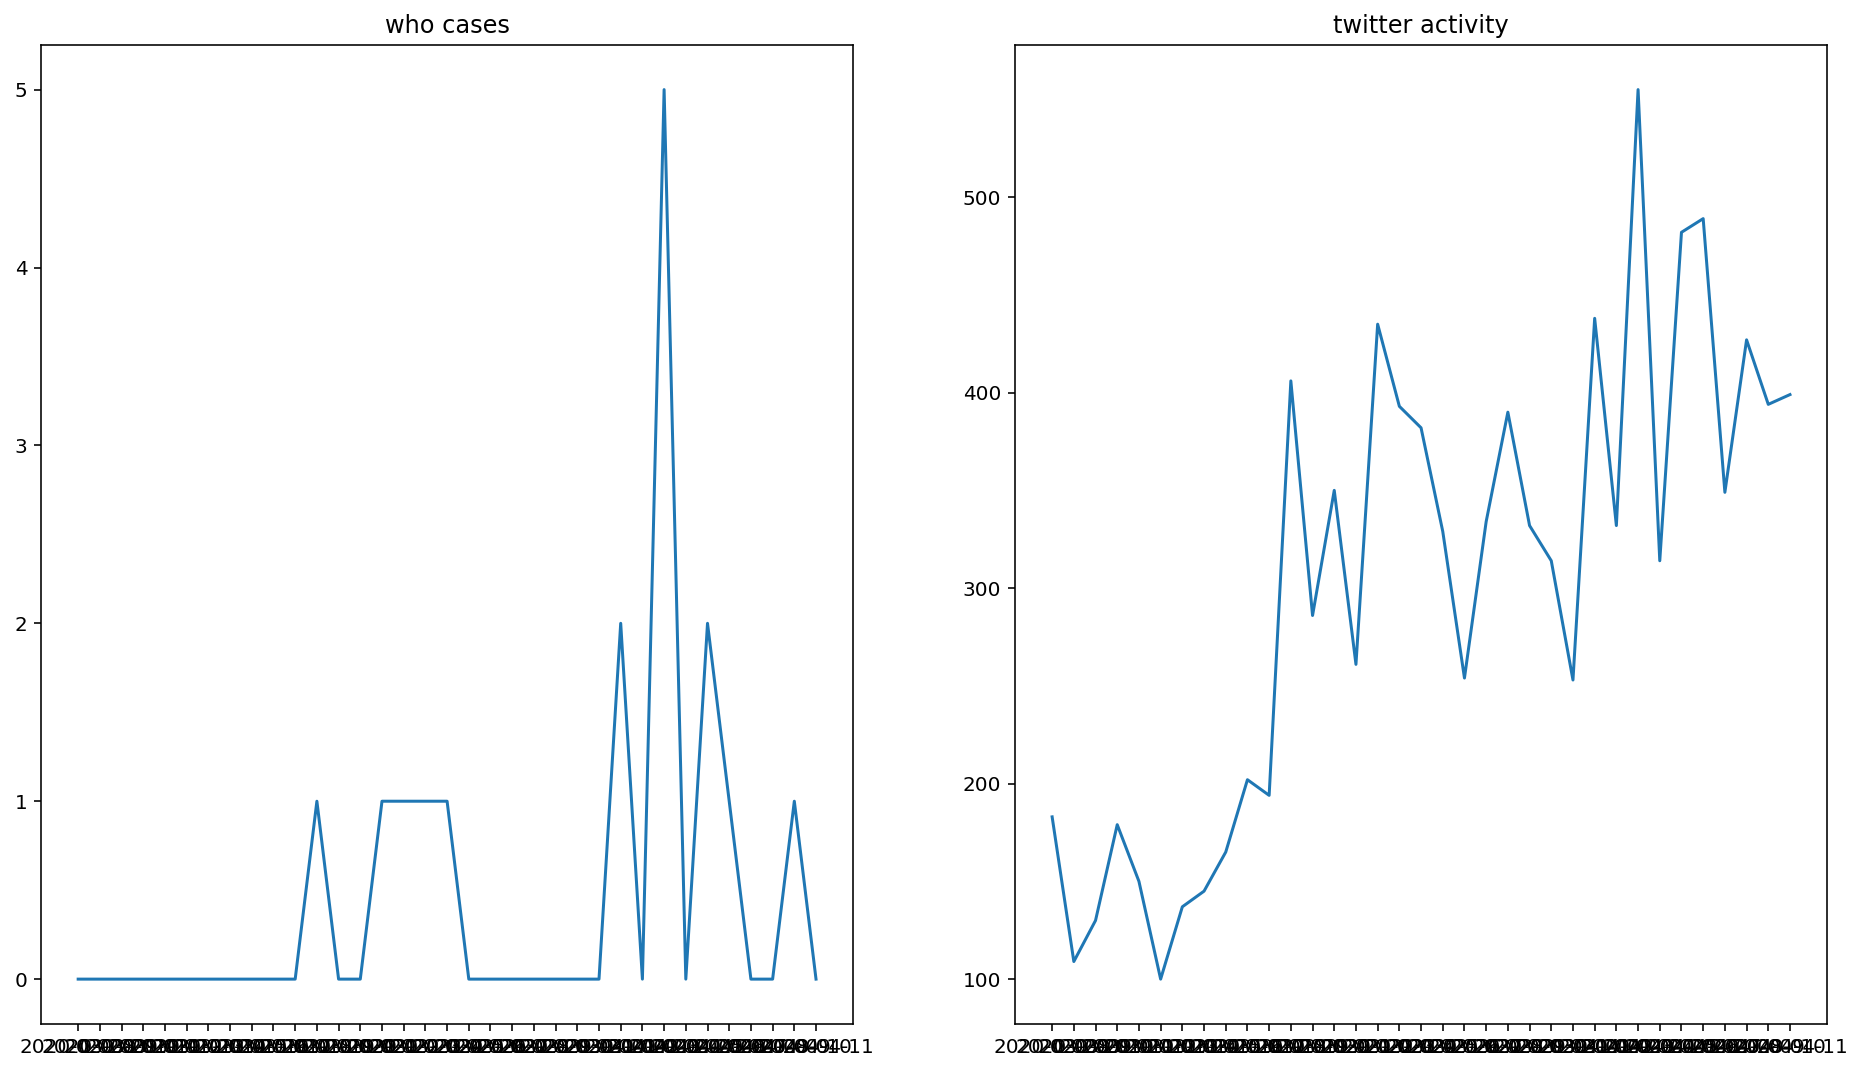

In [74]:
canada_who = who_data.get_data('FJ', who_source, valid_dates_range)
canada_twitter = twitter_data.get_data('FJ', valid_dates_range)

plt.subplot(1, 2, 1)
plt.plot(canada_who)
plt.title('who cases')

plt.subplot(1, 2, 2)
plt.plot(canada_twitter)
plt.title('twitter activity')